In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device ='cuda' if torch.cuda.is_available() else 'cpu'
print("PyTorch is Running on:",device)

PyTorch is Running on: cuda


In [2]:
df = pd.read_csv("Data/riceClassification.csv") 
df.head(3)

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1


## Data Preprocessing

In [3]:
df.dropna(inplace=True) 
df.drop(columns=['id'], axis=1, inplace=True) 
print("Shape of Dataset: ",df.shape)
print("Unique Values in Class Columns: ",df["Class"].unique())
print("Number of Unique Values in Class Column", df.Class.value_counts())
print()

Shape of Dataset:  (18185, 11)
Unique Values in Class Columns:  [1 0]
Number of Unique Values in Class Column Class
1    9985
0    8200
Name: count, dtype: int64



In [4]:
from sklearn.preprocessing import MinMaxScaler
minMax = MinMaxScaler()
original_df = df.copy()
scaled_df = minMax.fit_transform(df)
new_df = pd.DataFrame(scaled_df, columns=df.columns)

In [5]:
new_df.head(2)

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.262097,0.165901,0.614922,0.149139,0.248903,0.337191,0.544960,0.244209,0.807934,0.032371,1.0
1,0.045525,0.005123,0.352934,0.168567,0.051726,0.066336,0.655171,0.036283,0.899898,0.037204,1.0


## Data Splitting

In [6]:
x = np.array(new_df.iloc[:, :-1])
y = np.array(new_df.iloc[:, -1])
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y) # used for classification to keep the number 0 and 1 balanced in the data split
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print("Shape of x_train: ",x_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of x_val: ",x_val.shape)

Shape of x_train:  (12729, 10)
Shape of x_test:  (2728, 10)
Shape of x_val:  (2728, 10)


## Dataset Object

In [7]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [8]:
training_data = dataset(x_train, y_train)
validation_data = dataset(x_val, y_val)
testing_data = dataset(x_test, y_test)

In [9]:
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)

In [10]:
for x,y in train_dataloader:
    print("Shape of x: ",x.shape)
    print("Shape of y: ",y.shape)
    break

Shape of x:  torch.Size([8, 10])
Shape of y:  torch.Size([8])


In [11]:
HIDDEN_LAYERS = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.input_layer = nn.Linear(x.shape[1], HIDDEN_LAYERS)
        self.linear = nn.Linear(HIDDEN_LAYERS, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.activation(x)
        return x
        

In [12]:
model = MyModel().to(device)

In [13]:
summary(model, (x.shape[1],), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [14]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [15]:
total_loss_train_plot = []
total_loss_val_plot = []
total_accuracy_train_plot = [] 
total_accruacy_val_plot = []
epochs = 10

In [16]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for data in train_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)
     

Epoch no. 1 Train Loss: 0.3785 Train Accuracy: 95.7970 Validation Loss: 0.0208 Validation Accuracy: 98.7903
Epoch no. 2 Train Loss: 0.0865 Train Accuracy: 98.4052 Validation Loss: 0.0140 Validation Accuracy: 98.9370
Epoch no. 3 Train Loss: 0.0738 Train Accuracy: 98.4995 Validation Loss: 0.0127 Validation Accuracy: 98.9370
Epoch no. 4 Train Loss: 0.0711 Train Accuracy: 98.4681 Validation Loss: 0.0123 Validation Accuracy: 98.8636
Epoch no. 5 Train Loss: 0.0709 Train Accuracy: 98.4445 Validation Loss: 0.0126 Validation Accuracy: 98.7170
Epoch no. 6 Train Loss: 0.0704 Train Accuracy: 98.5152 Validation Loss: 0.0119 Validation Accuracy: 98.9003
Epoch no. 7 Train Loss: 0.0703 Train Accuracy: 98.4995 Validation Loss: 0.0120 Validation Accuracy: 98.9003
Epoch no. 8 Train Loss: 0.0704 Train Accuracy: 98.3974 Validation Loss: 0.0119 Validation Accuracy: 98.9003
Epoch no. 9 Train Loss: 0.0700 Train Accuracy: 98.4602 Validation Loss: 0.0121 Validation Accuracy: 98.8270
Epoch no. 10 Train Loss: 0.0

## Testing

In [17]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/x_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.83%


## Visual 

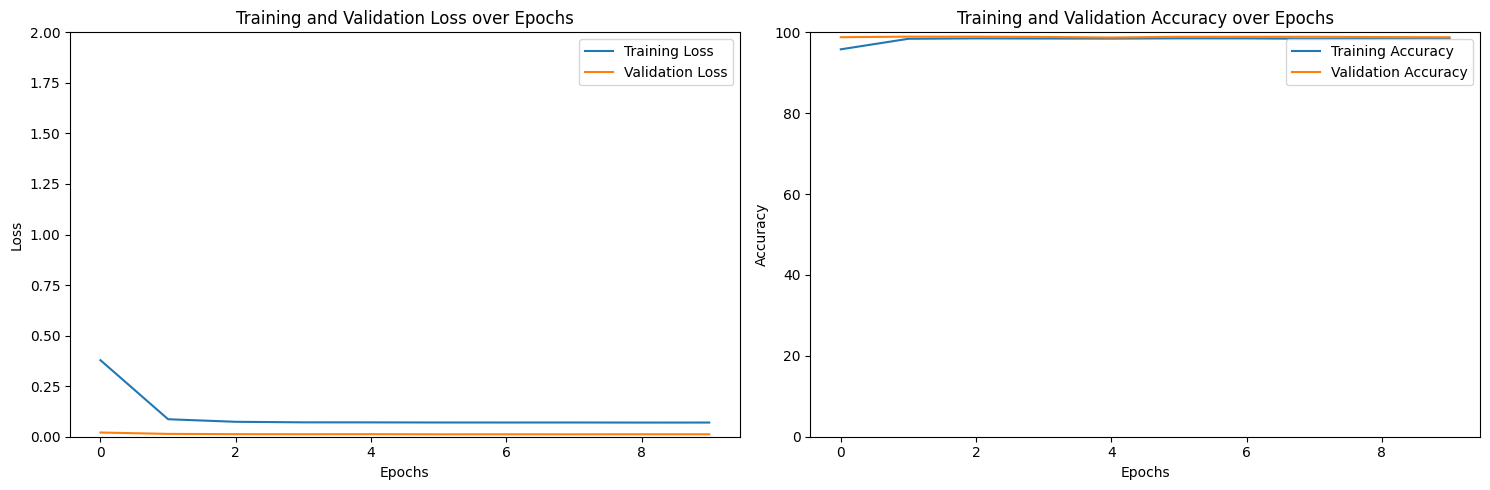

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

## Inference

In [19]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))
     

tensor([0.6444], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  1


In [20]:
import os 
save_dir = 'models/'
filename = 'my_model_weights.pth'
save_path = os.path.join(save_dir, filename)

# Save state_dict
torch.save(model.state_dict(), save_path)